# Section 4.1.2. VAE

## 1. Training Stage

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
hts_df = pd.read_csv('hts_example.csv', index_col=None)
    
num_categories = {}
for column in hts_df.columns:
    num_unique = hts_df[column].nunique()
    num_categories[column] = num_unique
    print(f"Column '{column}' has {num_unique} unique categories.")

Column 'start_type' has 5 unique categories.
Column 'act_num' has 9 unique categories.
Column 'mode_num' has 9 unique categories.
Column 'end_type' has 5 unique categories.


In [3]:
def dequantize_data(data):
    data_continuous = data.copy().astype(float)
    for column in data_continuous.columns:
        data_continuous[column] += np.random.uniform(0, 1, size=data_continuous.shape[0])
    return data_continuous

data_continuous = dequantize_data(hts_df)
data_tensor = torch.tensor(data_continuous.values, dtype=torch.float32).to(device)

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(hidden_dim, z_dim)
        self.log_var_layer = nn.Linear(hidden_dim, z_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        log_var = self.log_var_layer(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var

In [5]:
z_dim = 64
hidden_dim = 512

input_dim = data_tensor.shape[1]
vae_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, z_dim=z_dim).to(device)

In [6]:
learning_rate=1e-3
batch_size=512
num_epochs=30

optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)

dataset = torch.utils.data.TensorDataset(data_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

vae_model.train()
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    for batch in dataloader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_reconstructed, mu, log_var = vae_model(x)

        # Reconstruction loss (MSE)
        recon_loss = nn.functional.mse_loss(x_reconstructed, x, reduction='sum')

        # KL divergence
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total loss
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % 3 == 0 or epoch == 1:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/30], Loss: 1147517.6324
Epoch [3/30], Loss: 738154.4672
Epoch [6/30], Loss: 698243.8552
Epoch [9/30], Loss: 686367.4851
Epoch [12/30], Loss: 680260.0078
Epoch [15/30], Loss: 676005.5466
Epoch [18/30], Loss: 674586.7935
Epoch [21/30], Loss: 672143.5369
Epoch [24/30], Loss: 670837.1051
Epoch [27/30], Loss: 669764.3563
Epoch [30/30], Loss: 667615.0798


## 2. Testing Stage

In [7]:
columns = ['start_type', 'act_num', 'mode_num', 'end_type']
num_samples=3000

vae_model.eval()

with torch.no_grad():
    z = torch.randn(num_samples, z_dim).to(device)
    samples = vae_model.decode(z).cpu().numpy()

generated_categories = pd.DataFrame(samples, columns=columns)
for column in columns:
    max_cat = num_categories[column] - 1
    generated_categories[column] = np.floor(generated_categories[column]).astype(int)
    generated_categories[column] = np.clip(generated_categories[column], 0, max_cat)

<ipython-input-8-aa13fff6afbe>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=base_font_size+4)


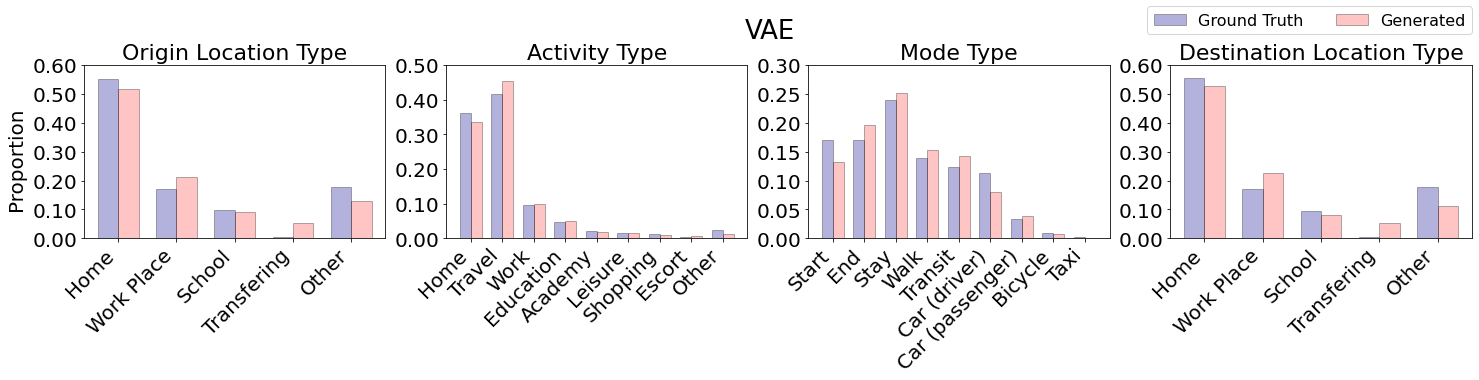

In [8]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']
base_font_size = 16

fig, axs = plt.subplots(1, 4, figsize=(20, 3))

formatter = FormatStrFormatter('%.2f')

fig.tight_layout(h_pad=1, w_pad=3)

ylim_list = [0.60, 0.5, 0.3, 0.6]
sub_title_list = ['Origin Location Type', 'Activity Type', 'Mode Type', 'Destination Location Type']
bar_width = 0.35
offset = bar_width / 2

xtick_labels_list = [
    ['Home', 'Work Place', 'School', 'Transfering', 'Other'],  # Start Location Type
    ['Home', 'Travel', 'Work', 'Education', 'Academy', 'Leisure', 'Shopping', 'Escort', 'Other'],  # Activity Type
    ['Start', 'End', 'Stay', 'Walk', 'Transit', 'Car (driver)', 'Car (passenger)', 'Bicycle', 'Taxi'],  # Mode Type
    ['Home', 'Work Place', 'School', 'Transfering', 'Other']  # End Location Type
]

for column, ylim, sub_title, xtick_labels, ax in zip(columns, ylim_list, sub_title_list, xtick_labels_list, axs.flatten()):
    
    # Ground truth
    unique_hts, counts_hts = np.unique(hts_df[column], return_counts=True)
    ax.set_ylim([0, ylim])
    positions_hts = np.arange(len(unique_hts))
    ax.bar(positions_hts - offset, counts_hts / counts_hts.sum(), 
           width=bar_width, color='#00008F', edgecolor='black', alpha=0.3, label='Ground Truth')
    
    # Generated data
    unique_gen, counts_gen = np.unique(generated_categories[column], return_counts=True)
    positions_gen = np.arange(len(unique_gen))
    ax.bar(positions_gen + offset, counts_gen / counts_gen.sum(), 
           width=bar_width, color='#FF4040', edgecolor='black', alpha=0.3, label='Generated')
    
    ax.set_xticks([int(x) for x in unique_hts])
    ax.set_xticklabels(xtick_labels, fontsize=base_font_size+4, rotation=45, ha='right')
    
    ax.yaxis.set_major_formatter(formatter)
    ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=base_font_size+4)

    ax.set_title(sub_title, fontsize=base_font_size+6)

fig.suptitle('VAE', fontsize=base_font_size+10, y=1.15)
fig.text(-0.03, 0.5, 'Proportion', va='center', rotation='vertical', fontsize=base_font_size+4)

fig.legend(['Ground Truth', 'Generated'], loc='upper right', ncol=2, fontsize=base_font_size, 
           bbox_to_anchor=(0.993, 1.24), bbox_transform=fig.transFigure)

plt.savefig(f'img/vae_discrete.png', bbox_inches='tight', dpi=400)
plt.show()
plt.close()